In [48]:
# import modules
import pandas
from sklearn import svm
import tensorflow as tf
import numpy as np
from sklearn.decomposition import PCA
from pylab import *
import struct
import keras as ks
import logging
from keras.layers import Dense, Activation, Flatten, Convolution2D
from keras.utils import np_utils
from keras.models import model_from_json
from keras import backend as K

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

import matplotlib.pyplot as plt
from skimage import io
import numpy as np
from PIL import Image 
from scipy import misc
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
# ...

## 数据读取和预处理
label 3个 => 4个
- normal: 2462
- cpu   : 373
- mem   : 266
- io    : 592

In [2]:
# 3888 * 51 with 4 labels
data_raw = pandas.read_csv("data/host10280-labeled-2.csv")
data = np.array(data_raw)
data_raw = pandas.read_csv("data/host10274-labeled-2.csv")
data = np.concatenate((data,np.array(data_raw)),axis=0)
data_raw = pandas.read_csv("data/host10283-labeled-2.csv")
data = np.concatenate((data,np.array(data_raw)),axis=0)

# 50 = 2 ids + 45 features + 3 labels
# ids: host + clock
# labels: normal, cpu, mem, io
data_features = data[:,2:47]
data_labels = data[:,46:50]

len(data_labels)
for i in range(len(data_labels)):
    item = data_labels[i]
    if item[1] == 0 and item[2] == 0 and item[3] == 0:
        data_labels[i][0] = 1
    else:
        data_labels[i][0] = 0

data_class = [] # 0 ~ 3
for label in data_labels:
    data_class.append(np.dot([0,1,2,3],label))
data_class = np.array(data_class,dtype="int")

print(sum(data_class == 0))
print(sum(data_class == 1))
print(sum(data_class == 2))
print(sum(data_class == 3))
print(data_class.shape)

2462
373
266
592
(3693,)


In [3]:
# 1231 abnormal
num_sample = sum(data_class != 0)
# select 1231 normal samples randomly
data_tmp = data_features[data_class == 0]
index_tmp = np.arange(0,data_tmp.shape[0],data_tmp.shape[0]/num_sample)[0:num_sample]
data_normal_tmp = data_tmp[index_tmp]

data_features = np.concatenate((data_normal_tmp,                 data_features[data_class != 0]),axis=0)
data_labels   = np.concatenate((np.array([[1,0,0,0]]*num_sample),data_labels[data_class != 0]),  axis=0)
data_class    = np.concatenate((np.array([0]*num_sample),        data_class[data_class != 0]),   axis=0)

## 划分训练集和验证集
- 训练集: 80%
- 验证集: 20%

In [4]:
# feature scaling
for i in range(data_features.shape[1]):
    d_min = data_features[:,i].min()
    d_max = data_features[:,i].max()
    if d_min == d_max:
        data_features[:,i] = 1
        continue
    data_features[:,i] -= d_min
    data_features[:,i] /= (d_max - d_min)

num_tosample = len(data_class)
index_test = np.arange(0,num_tosample,5)
index_train = np.array(list(set(np.arange(0,num_tosample,1)) - set(index_test)))

data_train = data_features[index_train]
labels_train = data_labels[index_train]
class_train = data_class[index_train]
data_test = data_features[index_test]
labels_test = data_labels[index_test]
class_test = data_class[index_test]
print(data_train.shape)
print(labels_train.shape)
print(class_train.shape)
print(data_test.shape)
print(labels_test.shape)
print(class_test.shape)

(1969, 45)
(1969, 4)
(1969,)
(493, 45)
(493, 4)
(493,)


In [45]:
# save loss and acc
class LossHistory(ks.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        iindex = np.arange(0,len(self.losses[loss_type]),len(self.losses[loss_type])/200)
        iters = np.array(iters)
        plt.figure()
        # acc
        plt.plot(iters[iindex], np.array(self.accuracy[loss_type])[iindex], 'r', label='train acc')
        # loss
        plt.plot(iters[iindex], np.array(self.losses[loss_type])[iindex], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters[iindex], np.array(self.val_acc[loss_type])[iindex], 'b', label='val acc')
            # val_loss
            plt.plot(iters[iindex], np.array(self.val_loss[loss_type])[iindex], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.savefig('fig.png')
        plt.show()

## 神经网络
45 => 128 => 64 => 32 => 16 => 4

In [73]:
model = ks.models.Sequential()
model.add(Dense(128, input_dim=data_features.shape[1]))
model.add(Activation('relu'))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(4))
model.add(Activation('softmax'))
history = LossHistory()

model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])
model.fit(x=data_train,y=labels_train,batch_size=128,nb_epoch=5000,verbose=1,validation_data=(data_test,labels_test),callbacks=[history])

Train on 1969 samples, validate on 493 samples
Epoch 1/400
1969/1969 [==============================] - 1s - loss: 1.3323 - acc: 0.4718 - val_loss: 1.2468 - val_acc: 0.6085
Epoch 2/400
1969/1969 [==============================] - 0s - loss: 1.1549 - acc: 0.6247 - val_loss: 1.0164 - val_acc: 0.6126
Epoch 3/400
1969/1969 [==============================] - 0s - loss: 0.8809 - acc: 0.7080 - val_loss: 0.7829 - val_acc: 0.6024
Epoch 4/400
1969/1969 [==============================] - 0s - loss: 0.7075 - acc: 0.6912 - val_loss: 0.5957 - val_acc: 0.7485
Epoch 5/400
1969/1969 [==============================] - 0s - loss: 0.5172 - acc: 0.7902 - val_loss: 0.4565 - val_acc: 0.8479
Epoch 6/400
1969/1969 [==============================] - 0s - loss: 0.4927 - acc: 0.7913 - val_loss: 0.3974 - val_acc: 0.8580
Epoch 7/400
1969/1969 [==============================] - 0s - loss: 0.3788 - acc: 0.8558 - val_loss: 0.3647 - val_acc: 0.8580
Epoch 8/400
1969/1969 [==============================] - 0s - loss: 0.3

1969/1969 [==============================] - 0s - loss: 0.2666 - acc: 0.8537 - val_loss: 0.2613 - val_acc: 0.8600
Epoch 65/400
1969/1969 [==============================] - 0s - loss: 0.2632 - acc: 0.8690 - val_loss: 0.2717 - val_acc: 0.9026
Epoch 66/400
1969/1969 [==============================] - 0s - loss: 0.2626 - acc: 0.8685 - val_loss: 0.2617 - val_acc: 0.8600
Epoch 67/400
1969/1969 [==============================] - 0s - loss: 0.2625 - acc: 0.8725 - val_loss: 0.2672 - val_acc: 0.8600
Epoch 68/400
1969/1969 [==============================] - 0s - loss: 0.2616 - acc: 0.8700 - val_loss: 0.2648 - val_acc: 0.8600
Epoch 69/400
1969/1969 [==============================] - 0s - loss: 0.2614 - acc: 0.8614 - val_loss: 0.2639 - val_acc: 0.8925
Epoch 70/400
1969/1969 [==============================] - 0s - loss: 0.2638 - acc: 0.8685 - val_loss: 0.2614 - val_acc: 0.8803
Epoch 71/400
1969/1969 [==============================] - 0s - loss: 0.2629 - acc: 0.8659 - val_loss: 0.2851 - val_acc: 0.86

1969/1969 [==============================] - 0s - loss: 0.2298 - acc: 0.8908 - val_loss: 0.2472 - val_acc: 0.8641
Epoch 128/400
1969/1969 [==============================] - 0s - loss: 0.2366 - acc: 0.8837 - val_loss: 0.2437 - val_acc: 0.8600
Epoch 129/400
1969/1969 [==============================] - 0s - loss: 0.2445 - acc: 0.8690 - val_loss: 0.2487 - val_acc: 0.8844
Epoch 130/400
1969/1969 [==============================] - 0s - loss: 0.2342 - acc: 0.8903 - val_loss: 0.2335 - val_acc: 0.8783
Epoch 131/400
1969/1969 [==============================] - 0s - loss: 0.2309 - acc: 0.8939 - val_loss: 0.2306 - val_acc: 0.9108
Epoch 132/400
1969/1969 [==============================] - 0s - loss: 0.2374 - acc: 0.8812 - val_loss: 0.2392 - val_acc: 0.9047
Epoch 133/400
1969/1969 [==============================] - ETA: 0s - loss: 0.1982 - acc: 0.921 - 0s - loss: 0.2207 - acc: 0.8999 - val_loss: 0.2689 - val_acc: 0.8418
Epoch 134/400
1969/1969 [==============================] - 0s - loss: 0.2417 - a

1969/1969 [==============================] - 0s - loss: 0.1895 - acc: 0.9121 - val_loss: 0.2696 - val_acc: 0.8560
Epoch 190/400
1969/1969 [==============================] - 0s - loss: 0.1879 - acc: 0.9096 - val_loss: 0.2258 - val_acc: 0.8864
Epoch 191/400
1969/1969 [==============================] - 0s - loss: 0.1881 - acc: 0.9116 - val_loss: 0.2487 - val_acc: 0.8499
Epoch 192/400
1969/1969 [==============================] - 0s - loss: 0.1871 - acc: 0.9167 - val_loss: 0.1927 - val_acc: 0.9229
Epoch 193/400
1969/1969 [==============================] - 0s - loss: 0.1901 - acc: 0.9121 - val_loss: 0.2302 - val_acc: 0.8824
Epoch 194/400
1969/1969 [==============================] - 0s - loss: 0.2012 - acc: 0.9055 - val_loss: 0.2107 - val_acc: 0.8945
Epoch 195/400
1969/1969 [==============================] - 0s - loss: 0.1808 - acc: 0.9167 - val_loss: 0.1968 - val_acc: 0.9108
Epoch 196/400
1969/1969 [==============================] - 0s - loss: 0.1929 - acc: 0.9086 - val_loss: 0.2404 - val_ac

1969/1969 [==============================] - 0s - loss: 0.1567 - acc: 0.9304 - val_loss: 0.1749 - val_acc: 0.9249
Epoch 254/400
1969/1969 [==============================] - 0s - loss: 0.1408 - acc: 0.9385 - val_loss: 0.2258 - val_acc: 0.8722
Epoch 255/400
1969/1969 [==============================] - 0s - loss: 0.1685 - acc: 0.9198 - val_loss: 0.1623 - val_acc: 0.9229
Epoch 256/400
1969/1969 [==============================] - 0s - loss: 0.1614 - acc: 0.9162 - val_loss: 0.1944 - val_acc: 0.9067
Epoch 257/400
1969/1969 [==============================] - 0s - loss: 0.1704 - acc: 0.9172 - val_loss: 0.1823 - val_acc: 0.9148
Epoch 258/400
1969/1969 [==============================] - 0s - loss: 0.1464 - acc: 0.9365 - val_loss: 0.2415 - val_acc: 0.9026
Epoch 259/400
1969/1969 [==============================] - 0s - loss: 0.1664 - acc: 0.9157 - val_loss: 0.1787 - val_acc: 0.9067
Epoch 260/400
1969/1969 [==============================] - 0s - loss: 0.1469 - acc: 0.9360 - val_loss: 0.1787 - val_ac

1969/1969 [==============================] - 0s - loss: 0.1320 - acc: 0.9330 - val_loss: 0.1809 - val_acc: 0.9128
Epoch 318/400
1969/1969 [==============================] - 0s - loss: 0.1631 - acc: 0.9187 - val_loss: 0.1599 - val_acc: 0.9310
Epoch 319/400
1969/1969 [==============================] - 0s - loss: 0.1371 - acc: 0.9330 - val_loss: 0.2104 - val_acc: 0.9209
Epoch 320/400
1969/1969 [==============================] - 0s - loss: 0.1431 - acc: 0.9335 - val_loss: 0.2076 - val_acc: 0.9087
Epoch 321/400
1969/1969 [==============================] - 0s - loss: 0.1326 - acc: 0.9375 - val_loss: 0.1582 - val_acc: 0.9128
Epoch 322/400
1969/1969 [==============================] - 0s - loss: 0.1434 - acc: 0.9380 - val_loss: 0.1645 - val_acc: 0.9209
Epoch 323/400
1969/1969 [==============================] - 0s - loss: 0.1439 - acc: 0.9319 - val_loss: 0.1591 - val_acc: 0.9290
Epoch 324/400
1969/1969 [==============================] - 0s - loss: 0.1312 - acc: 0.9401 - val_loss: 0.1556 - val_ac

1969/1969 [==============================] - 0s - loss: 0.1260 - acc: 0.9401 - val_loss: 0.1988 - val_acc: 0.9148
Epoch 382/400
1969/1969 [==============================] - 0s - loss: 0.1298 - acc: 0.9406 - val_loss: 0.1650 - val_acc: 0.9270
Epoch 383/400
1969/1969 [==============================] - 0s - loss: 0.1333 - acc: 0.9375 - val_loss: 0.1597 - val_acc: 0.9249
Epoch 384/400
1969/1969 [==============================] - 0s - loss: 0.1281 - acc: 0.9406 - val_loss: 0.1564 - val_acc: 0.9310
Epoch 385/400
1969/1969 [==============================] - 0s - loss: 0.1198 - acc: 0.9462 - val_loss: 0.1329 - val_acc: 0.9513
Epoch 386/400
1969/1969 [==============================] - 0s - loss: 0.1497 - acc: 0.9289 - val_loss: 0.1631 - val_acc: 0.9229
Epoch 387/400
1969/1969 [==============================] - 0s - loss: 0.1315 - acc: 0.9411 - val_loss: 0.2254 - val_acc: 0.9006
Epoch 388/400
1969/1969 [==============================] - 0s - loss: 0.1326 - acc: 0.9355 - val_loss: 0.1606 - val_ac

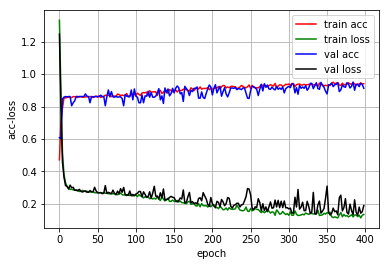

In [74]:
history.loss_plot('epoch')

In [62]:
def predict(model,data):
    tmp_res = model.predict(data)
    res = []
    for item in tmp_res:
        res.append(np.where(item == max(item))[0][0])
    return np.array(res)

In [70]:
y_true = class_train
y_pred = predict(model,data_train)
target_names = ['normal', 'cpu', 'mem', 'io']
print("train: {}".format(clf.score(mid_features_test, class_test)))
print(classification_report(y_true, y_pred, target_names=target_names))

# print("test: {}".format(clf.score(mid_features_test, class_test)))
y_true = class_test
y_pred = predict(model,data_test)
print("test: {}".format(sum(y_true == y_pred)/float(len(y_true))))
print(classification_report(y_true, y_pred, target_names=target_names))

train: 0.987829614604
             precision    recall  f1-score   support

     normal       1.00      1.00      1.00       984
        cpu       0.96      1.00      0.98       299
        mem       1.00      0.96      0.98       212
         io       1.00      0.99      1.00       474

avg / total       0.99      0.99      0.99      1969

test: 0.983772819473
             precision    recall  f1-score   support

     normal       1.00      1.00      1.00       247
        cpu       0.93      1.00      0.96        74
        mem       1.00      0.93      0.96        54
         io       0.98      0.97      0.97       118

avg / total       0.98      0.98      0.98       493



## 神经网络 + SVM
45 => 128 => 64 => 32 => 16 => SVM

In [53]:
get_feature = K.function([model.layers[0].input],[model.layers[4].output])
mid_features_train = get_feature([data_train])[0]
mid_features_test  = get_feature([data_test])[0]
clf = svm.SVC()
clf.fit(mid_features_train, class_train)

print("train: {}".format(clf.score(mid_features_train, class_train)))
y_true = class_train
y_pred = clf.predict(mid_features_train)
target_names = ['normal', 'cpu', 'mem', 'io']
print(classification_report(y_true, y_pred, target_names=target_names))

print("test: {}".format(clf.score(mid_features_test, class_test)))
y_true = class_test
y_pred = clf.predict(mid_features_test)
print(classification_report(y_true, y_pred, target_names=target_names))

0.98781107161
0.987829614604
train: 0.98781107161
             precision    recall  f1-score   support

     normal       1.00      1.00      1.00       984
        cpu       0.98      0.95      0.96       299
        mem       1.00      0.98      0.99       212
         io       0.96      0.99      0.98       474

avg / total       0.99      0.99      0.99      1969

test: 0.987829614604
             precision    recall  f1-score   support

     normal       1.00      1.00      1.00       247
        cpu       0.99      0.96      0.97        74
        mem       1.00      0.96      0.98        54
         io       0.96      0.99      0.97       118

avg / total       0.99      0.99      0.99       493



## 其他机器学习算法
- KNN
- 线性SVM
- 基于核函数的SVM (RBF SVM), Radial basis function kernel
- 决策树
- 随机森林

In [51]:
classifiers = [
    KNeighborsClassifier(4),
    svm.SVC(kernel="linear", C=0.025),
    svm.SVC(),
    DecisionTreeClassifier(max_depth=3),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
    ]
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Decision Tree",
         "Random Forest"]
for name, clf in zip(names,classifiers):
    clf.fit(data_train,class_train)
    print(name)
    print("train: {}".format(clf.score(data_train, class_train)))
    y_true = class_train
    y_pred = clf.predict(data_train)
    target_names = ['normal', 'cpu', 'mem', 'io']
    print(classification_report(y_true, y_pred, target_names=target_names))
    
    print("test: {}".format(clf.score(data_test, class_test)))
    y_true = class_test
    y_pred = clf.predict(data_test)
    print(classification_report(y_true, y_pred, target_names=target_names))
    print '\n'

Nearest Neighbors
train: 0.973590655155
             precision    recall  f1-score   support

     normal       1.00      1.00      1.00       984
        cpu       0.89      0.97      0.93       299
        mem       0.95      0.90      0.92       212
         io       0.98      0.96      0.97       474

avg / total       0.97      0.97      0.97      1969

test: 0.95537525355
             precision    recall  f1-score   support

     normal       1.00      1.00      1.00       247
        cpu       0.84      0.93      0.88        74
        mem       0.94      0.83      0.88        54
         io       0.95      0.93      0.94       118

avg / total       0.96      0.96      0.96       493



Linear SVM
train: 0.857287963433
             precision    recall  f1-score   support

     normal       1.00      1.00      1.00       984
        cpu       1.00      0.45      0.63       299
        mem       1.00      0.44      0.61       212
         io       0.63      1.00      0.77       4